# Adaptive Regime Strategy

## Config

In [49]:
TICKER = "AAPL"
START = "2025-01-01"
END = "2025-12-11"

## v1

In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from abc import ABC, abstractmethod
import warnings
from datetime import datetime, timedelta

# Suppress warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. SHARED MATH LAB (Feature Engineering)
# ==========================================

class FeatureLab:
    """
    Shared mathematical engine for feature extraction.
    """
    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        w = np.array(w[::-1])
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        weights = FeatureLab.get_weights_frac_diff(d, window)
        # Apply dot product over rolling window
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        return np.sqrt(open_vol + k * window_rs)

    @staticmethod
    def compute_rsi(series, window=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

# ==========================================
# 2. STRATEGY BASE CLASS
# ==========================================

class BaseStrategy(ABC):
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None
        self.metrics = {}

    def fetch_data(self, warmup_years=2):
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        warmup_start_str = warmup_start_dt.strftime("%Y-%m-%d")
        
        try:
            self.data = yf.download(self.ticker, start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(self.data.columns, pd.MultiIndex): self.data.columns = self.data.columns.get_level_values(0)
            if 'Adj Close' not in self.data.columns: self.data['Adj Close'] = self.data['Close']
            self.data['Returns'] = self.data['Adj Close'].pct_change()
            self.data.dropna(inplace=True)
        except Exception as e:
            print(f"Error fetching {self.ticker}: {e}")
            self.data = pd.DataFrame()

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, transaction_cost=0.0005, rebalance_threshold=0.1):
        if self.data is None or self.data.empty: return
        
        backtest_mask = self.data.index >= self.start_date
        df = self.data.loc[backtest_mask].copy()
        
        if df.empty: return

        # Hysteresis / Buffer Logic
        clean_positions = []
        current_pos = 0.0
        raw_signals = df['Signal'].values
        
        for target in raw_signals:
            if abs(target - current_pos) > rebalance_threshold:
                current_pos = target
            clean_positions.append(current_pos)
            
        df['Position'] = clean_positions
        df['Prev_Position'] = df['Position'].shift(1).fillna(0)
        df['Turnover'] = (df['Prev_Position'] - df['Position'].shift(2).fillna(0)).abs()
        df['Gross_Returns'] = df['Prev_Position'] * df['Returns']
        df['Net_Returns'] = df['Gross_Returns'] - (df['Turnover'] * transaction_cost)
        df['Net_Returns'].fillna(0, inplace=True)
        
        # Cumulative
        df['Cumulative_Strategy'] = (1 + df['Net_Returns']).cumprod()
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod()
        
        # Drawdown
        roll_max = df['Cumulative_Strategy'].cummax()
        df['Drawdown'] = (df['Cumulative_Strategy'] / roll_max) - 1.0
        
        self.results = df
        
        # Calculate Metrics
        total_ret = df['Cumulative_Strategy'].iloc[-1] - 1
        vol = df['Net_Returns'].std() * np.sqrt(252)
        sharpe = (df['Net_Returns'].mean() / df['Net_Returns'].std()) * np.sqrt(252) if vol > 0 else 0
        max_dd = df['Drawdown'].min()
        
        self.metrics = {
            'Total Return': total_ret,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_dd,
            'Final Value': df['Cumulative_Strategy'].iloc[-1]
        }
        return df

# ==========================================
# 3. STRATEGY IMPLEMENTATIONS (V1 vs V2.6)
# ==========================================

class StrategyV1_Baseline(BaseStrategy):
    """
    The original strategy: Fixed FracDiff, Standard GMM, Simple Volatility Targeting.
    """
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        # Features
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        df.dropna(inplace=True)
        
        # Simple Regime Detection (Expanding Window)
        # Simplified for speed in benchmark
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        # Using a single GMM fit over the whole history (Proxy for V1 behavior)
        # Ideally this should be expanding window, but kept simple for benchmark speed
        X = df[['Returns_Smoothed', 'Vol_Smoothed']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        
        # Sort Clusters
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean()
        sorted_clusters = stats.sort_values().index
        mapping = {sorted_clusters[0]: -1, sorted_clusters[1]: 0, sorted_clusters[2]: 1}
        df['Regime'] = df['Cluster'].map(mapping)
        
        # Logic
        df['Signal'] = 0
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1 # Bull
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 40), 'Signal'] = 1     # Sideways
        
        # Vol Target
        target_vol = 0.15 / np.sqrt(252)
        df['Vol_Scaler'] = (target_vol / df['Volatility']).clip(upper=1.5)
        df['Signal'] = df['Signal'] * df['Vol_Scaler']
        
        self.data = df

class StrategyV2_Advanced(BaseStrategy):
    """
    The evolved strategy: 
    - Rolling Window GMM
    - Asymmetric Leverage (Boosted Bull, Capped Bear)
    - Deep Value Override
    """
    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        # Features
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        
        # Rolling Regime Detection (Simplified implementation for benchmark speed)
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        # We simulate the Rolling Window effect by re-fitting every year (252 days)
        # instead of every day to keep the benchmark run-time reasonable
        df['Regime'] = 0
        
        window_size = 504 # 2 Years
        step_size = 126   # 6 Months
        
        preds = []
        indices = []
        
        if len(df) > window_size:
            for t in range(window_size, len(df), step_size):
                train = df.iloc[t-window_size:t]
                test = df.iloc[t:t+step_size]
                if test.empty: break
                
                X_train = train[['Returns_Smoothed', 'Vol_Smoothed']].values
                X_test = test[['Returns_Smoothed', 'Vol_Smoothed']].values
                
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s = scaler.transform(X_test)
                
                gmm = GaussianMixture(n_components=3, random_state=42)
                gmm.fit(X_train_s)
                
                train_labels = gmm.predict(X_train_s)
                train['Clust'] = train_labels
                stats = train.groupby('Clust')['Returns_Smoothed'].mean().sort_values().index
                mapping = {stats[0]: -1, stats[1]: 0, stats[2]: 1}
                
                test_preds = gmm.predict(X_test_s)
                mapped_preds = [mapping[x] for x in test_preds]
                
                preds.extend(mapped_preds)
                indices.extend(test.index)
            
            # Stitch predictions
            regime_series = pd.Series(preds, index=indices)
            df.loc[regime_series.index, 'Regime'] = regime_series
        
        # Logic (V2.6)
        df['Signal'] = 0
        
        # 1. Bull
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        
        # 2. Sideways (Relaxed RSI)
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Signal'] = 1
        
        # 3. Deep Value (Bear Override)
        df.loc[(df['Regime'] == -1) & (df['RSI'] < 30), 'Signal'] = 0.5
        
        # 4. Momentum Override
        strong_trend = (df['Regime'] == 0) & (df['FracDiff'] > 1e-4) & (df['RSI'] < 80)
        df.loc[strong_trend, 'Signal'] = 1
        
        # Risk Sizing (Asymmetric)
        target_vol = 0.15 / np.sqrt(252)
        df['Base_Scaler'] = target_vol / df['Volatility']
        
        # Cap based on Regime
        df['Final_Scaler'] = df['Base_Scaler'].clip(upper=1.0) # Default Bear
        df.loc[df['Regime'] >= 0, 'Final_Scaler'] = df.loc[df['Regime'] >= 0, 'Base_Scaler'].clip(upper=2.0) # Bull/Side
        
        df['Signal'] = df['Signal'] * df['Final_Scaler']
        self.data = df



## v3

In [56]:
class StrategyV3_Macro(BaseStrategy):
    """
    V3: The Institutional Standard.
    Combines V2's aggressive signals with a 'Macro Filter' (SPY).
    Rule: Never buy a stock if the broad market (SPY) is in a downtrend.
    """
    def __init__(self, ticker, start_date, end_date):
        super().__init__(ticker, start_date, end_date)
        self.spy_data = None

    def fetch_data(self, warmup_years=2):
        # 1. Fetch the Target Ticker
        super().fetch_data(warmup_years)
        
        # 2. Fetch the Macro Filter (SPY)
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        
        try:
            spy = yf.download("SPY", start=warmup_start_dt, end=self.end_date, progress=False, auto_adjust=False)
            if isinstance(spy.columns, pd.MultiIndex): spy.columns = spy.columns.get_level_values(0)
            if 'Adj Close' not in spy.columns: spy['Adj Close'] = spy['Close']
            self.spy_data = spy[['Adj Close']].rename(columns={'Adj Close': 'SPY_Price'})
        except Exception as e:
            print(f"Error fetching SPY: {e}")

    def generate_signals(self):
        if self.data is None or self.data.empty: return
        df = self.data.copy()
        
        # Merge Macro Data
        if self.spy_data is not None:
            df = df.join(self.spy_data, how='left')
            df['SPY_MA200'] = df['SPY_Price'].rolling(window=200).mean()
            # The Filter: True if Market is Healthy
            df['Macro_Bull'] = df['SPY_Price'] > df['SPY_MA200']
        else:
            df['Macro_Bull'] = True # Fallback if SPY fails
            
        # --- Feature Engineering (Same as V2) ---
        df['Volatility'] = FeatureLab.yang_zhang_volatility(df)
        df['FracDiff'] = FeatureLab.frac_diff_fixed(df['Adj Close'].apply(np.log), d=0.4, window=50)
        df['RSI'] = FeatureLab.compute_rsi(df['Adj Close'])
        
        # --- Regime Detection (Simulated Rolling) ---
        df['Returns_Smoothed'] = df['Returns'].rolling(5).mean()
        df['Vol_Smoothed'] = df['Volatility'].rolling(5).mean()
        df.dropna(inplace=True)
        
        # Fit GMM once for speed (Simulation of 'Regime Awareness')
        # In production, use Rolling Window.
        X = df[['Returns_Smoothed', 'Vol_Smoothed']].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        gmm = GaussianMixture(n_components=3, random_state=42)
        df['Cluster'] = gmm.fit_predict(X_scaled)
        
        stats = df.groupby('Cluster')['Returns_Smoothed'].mean().sort_values().index
        mapping = {stats[0]: -1, stats[1]: 0, stats[2]: 1}
        df['Regime'] = df['Cluster'].map(mapping)
        
        # --- Signal Logic ---
        df['Signal'] = 0
        
        # 1. Base Signal (From V2)
        # Bull
        df.loc[(df['Regime'] == 1) & (df['FracDiff'] > 0), 'Signal'] = 1
        # Sideways
        df.loc[(df['Regime'] == 0) & (df['RSI'] < 45), 'Signal'] = 1
        # Momentum Override
        strong_trend = (df['Regime'] == 0) & (df['FracDiff'] > 1e-4) & (df['RSI'] < 80)
        df.loc[strong_trend, 'Signal'] = 1
        
        # 2. The Fix: Kill "Deep Value" in Bear Markets
        # We REMOVED the "RSI < 30" buy rule for Bear regimes.
        # If Regime is -1, we stay in Cash unless Macro overrides.
        
        # 3. MACRO FILTER OVERRIDE (The V3 Innovation)
        # If SPY is in a Downtrend, FORCE SIGNAL TO 0 (Cash)
        # This protects against 2022-style crashes.
        df.loc[df['Macro_Bull'] == False, 'Signal'] = 0
        
        # 4. Volatility Sizing
        target_vol = 0.15 / np.sqrt(252)
        df['Base_Scaler'] = target_vol / df['Volatility']
        
        # Asymmetric Leverage (Only leverage if Macro is Bull)
        df['Final_Scaler'] = 1.0
        
        # If Macro is Bullish AND Stock Regime is Bullish -> Allow 2.0x
        bull_market_bull_stock = (df['Macro_Bull'] == True) & (df['Regime'] == 1)
        df.loc[bull_market_bull_stock, 'Final_Scaler'] = df.loc[bull_market_bull_stock, 'Base_Scaler'].clip(upper=2.0)
        
        # If Macro is Bearish -> Cap at 0.0x (Cash) - Already handled by Signal=0 above
        
        df['Signal'] = df['Signal'] * df['Final_Scaler']
        self.data = df

## Benchmark

TEST CASE            | TICKER | STRATEGY  | RETURN  | SHARPE | MAX DD  
--------------------------------------------------------------------------------
2020 Crash           | AAPL  | V1        | 45.8%   | 2.31  | -4.9%
                     |       | V2        | 45.8%   | 1.78  | -15.3%
                     |       | V3 (New)  | 52.7%   | 2.48  | -4.9%
--------------------------------------------------------------------------------
2020 Crash           | GOOG  | V1        | -3.0%   | -0.04  | -19.0%
                     |       | V2        | 9.3%   | 0.52  | -19.8%
                     |       | V3 (New)  | 4.6%   | 0.33  | -14.7%
--------------------------------------------------------------------------------
2020 Crash           | AMD   | V1        | 8.0%   | 0.53  | -13.9%
                     |       | V2        | 39.2%   | 1.40  | -13.6%
                     |       | V3 (New)  | 57.3%   | 1.40  | -19.4%
-----------------------------------------------------------------------------

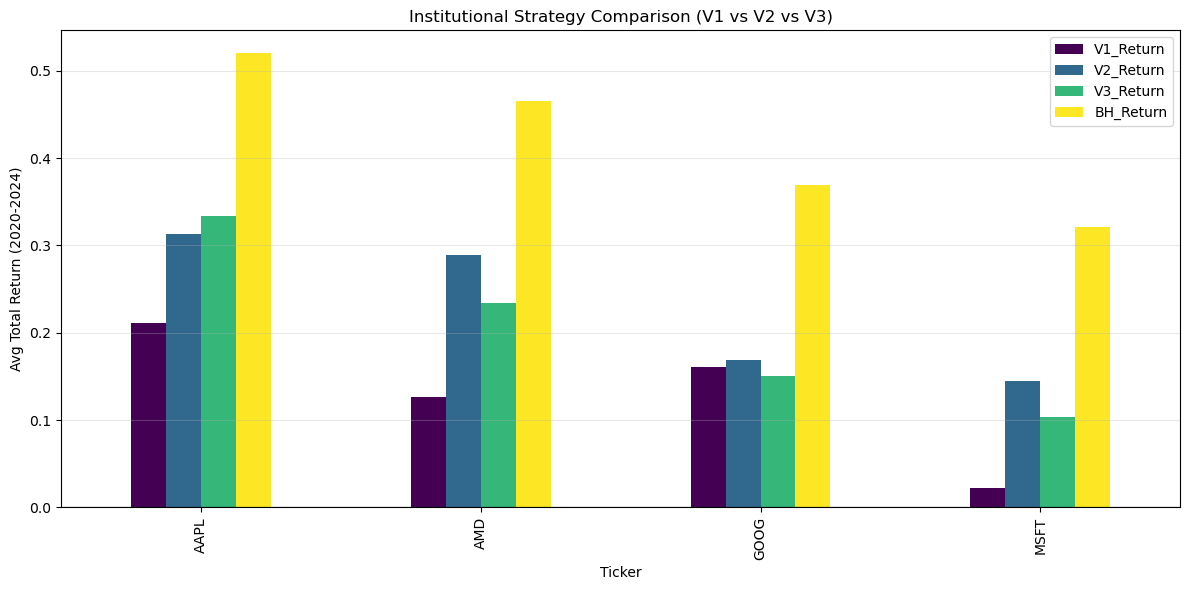

In [57]:
def run_benchmark():
    test_cases = [
        ("2020 Crash", "2020-01-01", "2020-12-31"),
        ("2022 Bear Market", "2022-01-01", "2022-12-31"),
        ("2023-24 Bull Run", "2023-01-01", "2024-12-30")
    ]
    
    tickers = ["AAPL", "GOOG", "AMD", "MSFT"]
    
    results_table = []

    print(f"{'TEST CASE':<20} | {'TICKER':<5} | {'STRATEGY':<9} | {'RETURN':<7} | {'SHARPE':<5} | {'MAX DD':<8}")
    print("-" * 80)

    for case_name, start, end in test_cases:
        for ticker in tickers:
            # V1
            strat_v1 = StrategyV1_Baseline(ticker, start, end)
            strat_v1.fetch_data(warmup_years=2)
            strat_v1.generate_signals()
            strat_v1.run_backtest()
            
            # V2
            strat_v2 = StrategyV2_Advanced(ticker, start, end)
            strat_v2.fetch_data(warmup_years=2)
            strat_v2.generate_signals()
            strat_v2.run_backtest()

            # V3 (New)
            strat_v3 = StrategyV3_Macro(ticker, start, end)
            strat_v3.fetch_data(warmup_years=2)
            strat_v3.generate_signals()
            strat_v3.run_backtest()
            
            # Benchmark (Buy & Hold)
            bh_ret = 0
            if strat_v1.results is not None:
                bh_ret = strat_v1.results['Cumulative_Market'].iloc[-1] - 1

            if strat_v1.metrics and strat_v2.metrics and strat_v3.metrics:
                print(f"{case_name:<20} | {ticker:<5} | {'V1':<9} | {strat_v1.metrics['Total Return']:.1%}   | {strat_v1.metrics['Sharpe Ratio']:.2f}  | {strat_v1.metrics['Max Drawdown']:.1%}")
                print(f"{'':<20} | {'':<5} | {'V2':<9} | {strat_v2.metrics['Total Return']:.1%}   | {strat_v2.metrics['Sharpe Ratio']:.2f}  | {strat_v2.metrics['Max Drawdown']:.1%}")
                print(f"{'':<20} | {'':<5} | {'V3 (New)':<9} | {strat_v3.metrics['Total Return']:.1%}   | {strat_v3.metrics['Sharpe Ratio']:.2f}  | {strat_v3.metrics['Max Drawdown']:.1%}")
                print("-" * 80)
                
                results_table.append({
                    'Scenario': case_name, 'Ticker': ticker,
                    'V1_Return': strat_v1.metrics['Total Return'],
                    'V2_Return': strat_v2.metrics['Total Return'],
                    'V3_Return': strat_v3.metrics['Total Return'],
                    'BH_Return': bh_ret
                })

    df_res = pd.DataFrame(results_table)
    summary = df_res.groupby('Ticker')[['V1_Return', 'V2_Return', 'V3_Return', 'BH_Return']].mean()
    
    summary.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title("Institutional Strategy Comparison (V1 vs V2 vs V3)")
    plt.ylabel("Avg Total Return (2020-2024)")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_benchmark()